In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
%cd Text_ming_project/

/content/drive/MyDrive/Text_ming_project


In [ ]:
%ls

 Apple_10K_form.pdf                      google-2018.pdf   google-2022.pdf
 en_core_web_sm-3.8.0-py3-none-any.whl   google-2019.pdf   requirements.txt
 goog-10-k-2023.pdf                      google-2020.pdf  'SEC Filing _ Microsoft Corporation.pdf'
 google-2017.pdf                         google-2021.pdf   Text_mining_project.ipynb


In [ ]:
%pip install pdfplumber PyPDF2
%pip install spacy
%pip wheel https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.8 MB/s eta 0:00:00
  File was already downloaded /content/drive/MyDrive/Text_ming_project/en_core_web_sm-3.8.0-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 60.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pdfplumber
import re
from PyPDF2 import PdfReader, PdfWriter
import matplotlib.pyplot as plt
import spacy

In [ ]:
pdf_path = "goog-10-k-2023.pdf"

In [ ]:
def page_extract(pdf_path, chunk_size):
  with pdfplumber.open(pdf_path) as pdf:

    toc_page = None #finding the table of content page

    for _, page in enumerate(pdf.pages):
        text = page.extract_text()
        if re.search(r'\btable of contents|index\b', text.lower(), re.IGNORECASE):
            toc_page = text
            break

  section = "Mine Safety Disclosures" #the last subheading that we want to get all the information from the 10Q form

  #print(toc_page)
  # To capture the page number right after the header
  part_i_page = re.search(rf"{section}.*?(\d+)", toc_page)

  count = int(part_i_page.group(1))

  reader = PdfReader(pdf_path)
  pdf_writer = PdfWriter()

  content = []

  for i in range(count + 2):
      a = pdf_writer.add_page(reader.pages[i]).extract_text()
      content.append(a)


  full_text = " ".join(content)

  words = full_text.split()  # Split the text into words
  chunks = []
  chunk = []

  current_size = 0

  for word in words:
        word_length = len(word) + 1
        if current_size + word_length > chunk_size:
            chunks.append(" ".join(chunk))
            chunk = []
            current_size = 0
        chunk.append(word)
        current_size += word_length


  if chunk:
        chunks.append(" ".join(chunk))

  return chunks

In [ ]:
google_content = page_extract(pdf_path,300)

In [ ]:
nlp = spacy.load('en_core_web_sm')

def pre_process(content):
    preprocess = []
    for i in range(len(content)):
      text = re.sub(r'\d+', '', content[i])
      text = re.sub(r'-', ' ', text)
      text = re.sub(r'[^\w\s]', '', text)
      text = re.sub(r'\s+', ' ', text).strip()
      text = re.sub(r'_+', '', text)
      text = text.lower()

      doc = nlp(text)

      #lemmatized_text = [token.lemma_ for token in doc]

      final = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

      preprocess.append(" ".join(final))

    return preprocess

In [ ]:
google_content_process = pre_process(google_content)

Inital/basic analysis of the text

In [ ]:
def term_frequencey(content,top_n):

    word_count = {}
    for para in content:
        words = list(para.split(" "))
        for word in words:
                if word not in word_count:
                    word_count[word] = 1
                elif word in word_count:
                    word_count[word] += 1

    sorted_word_count = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

    top_items = list(sorted_word_count.items())[:top_n]


    terms, values = zip(*top_items)

    plt.bar(terms, values)
    plt.xticks(rotation=45)
    return plt.show()

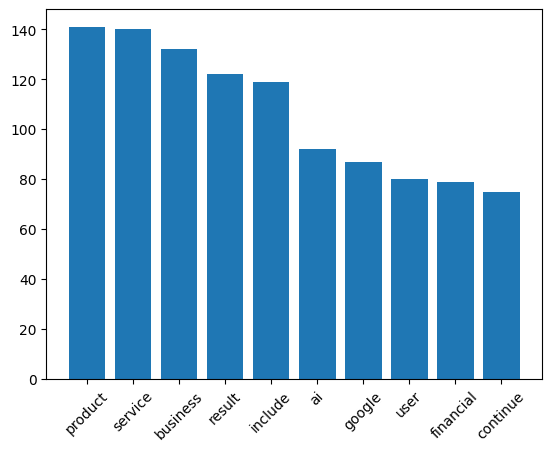

In [ ]:
term_frequencey(google_content_process,10)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def tf_idf(content, top_n):
  tfidf = TfidfVectorizer()

  result = tfidf.fit_transform(content)

  feature_names = np.array(tfidf.get_feature_names_out())

  # The TF-IDF scores
  sum_tfidf_scores = np.array(result.sum(axis=0)).flatten()

  term_tfidf = dict(zip(feature_names, sum_tfidf_scores))

  # Sorting
  sorted_term_tfidf = dict(sorted(term_tfidf.items(), key=lambda item: item[1], reverse=True))

  top_items = list(sorted_term_tfidf.items())[:top_n]


  terms, values = zip(*top_items)

  plt.bar(terms, values)
  plt.xticks(rotation=45)

  return plt.show()

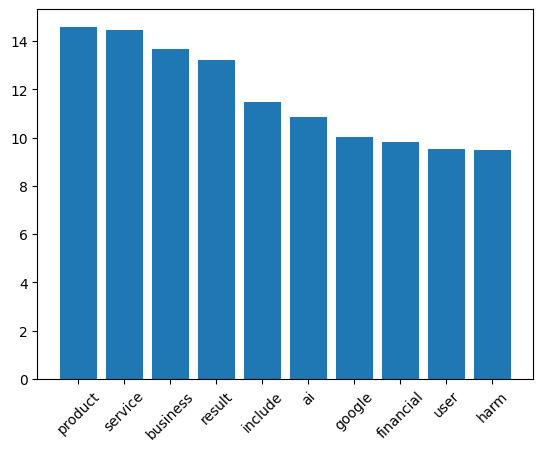

In [ ]:
tf_idf(google_content_process, 10)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def n_grams(content,n_gram, top_n):

  vectorizer = CountVectorizer(ngram_range=(n_gram, n_gram))
  X = vectorizer.fit_transform(content)
  ngrams = vectorizer.get_feature_names_out()
  ngram_counts = X.sum(axis=0).getA1() #https://numpy.org/doc/stable/reference/generated/numpy.matrix.A1.html

  n_gram_dic = dict(zip(ngrams, ngram_counts))

  sorted_n_gram_dic = dict(sorted(n_gram_dic.items(), key=lambda item: item[1], reverse=True))


  top_items = list(sorted_n_gram_dic.items())[:top_n]


  terms, values = zip(*top_items)

  plt.bar(terms, values)
  plt.xticks(rotation=90)

  return plt.show()

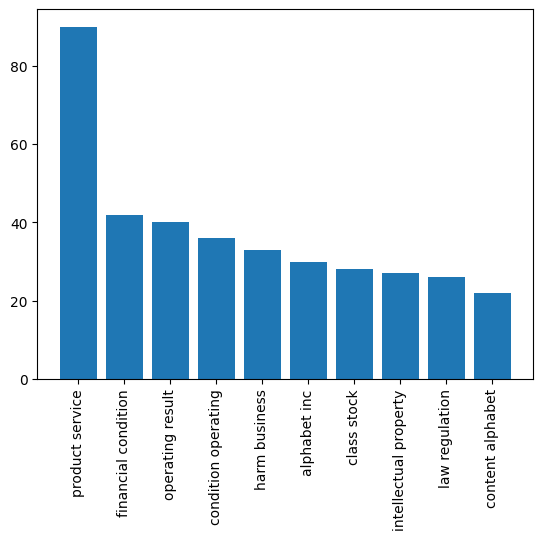

In [ ]:
n_grams(google_content_process,n_gram=2,top_n=10)

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

def train_lda_model(documents, num_topics, passes=1):
    dictionary = Dictionary(documents)

    corpus = [dictionary.doc2bow(doc) for doc in documents]
    dictionary[0]
    model = LdaModel(corpus=corpus, id2word=dictionary.id2token, num_topics=num_topics, passes=passes)
    return model

In [ ]:
lda_content = [content.split() for content in google_content_process]
model = train_lda_model(lda_content,num_topics=10,passes=10)
model.print_topics()

[(0,
  '0.022*"item" + 0.015*"security" + 0.014*"risk" + 0.010*"registrant" + 0.010*"statement" + 0.010*"include" + 0.009*"act" + 0.008*"financial" + 0.008*"report" + 0.008*"datum"'),
 (1,
  '0.028*"service" + 0.028*"product" + 0.018*"ai" + 0.013*"include" + 0.013*"google" + 0.011*"business" + 0.011*"change" + 0.009*"law" + 0.009*"result" + 0.008*"use"'),
 (2,
  '0.013*"product" + 0.012*"service" + 0.011*"business" + 0.010*"include" + 0.009*"company" + 0.008*"security" + 0.008*"continue" + 0.008*"incident" + 0.007*"management" + 0.006*"privacy"'),
 (3,
  '0.024*"service" + 0.022*"product" + 0.016*"google" + 0.013*"device" + 0.012*"continue" + 0.012*"user" + 0.012*"harm" + 0.009*"result" + 0.009*"business" + 0.008*"advertiser"'),
 (4,
  '0.016*"content" + 0.015*"stock" + 0.014*"class" + 0.013*"alphabet" + 0.011*"law" + 0.010*"include" + 0.008*"inc" + 0.008*"change" + 0.008*"regulation" + 0.007*"property"'),
 (5,
  '0.024*"stock" + 0.018*"class" + 0.014*"director" + 0.013*"share" + 0.013

BERTopic

In [ ]:
%pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
google_content_process

['united states securities exchange commission washington dc form k mark annual report pursuant section d security exchange act fiscal year end',
 'december transition report pursuant section d security exchange act transition period commission file number alphabet inc exact registrant specify charter',
 'delaware state jurisdiction incorporation organization irs employer identification amphitheatre parkway mountain view address principal executive office include zip code',
 'registrant telephone number include area code security register pursuant section b act title class trading symbol exchange register class common stock par value googl nasdaq stock market llc nasdaq global select market class c',
 'capital stock par value goog nasdaq stock market llc nasdaq global select market security register pursuant section g act title class indicate check mark registrant know seasoned issuer',
 'define rule security act yes indicate check mark registrant require file report pursuant section s

In [ ]:
from bertopic import BERTopic


topic_model_2023 = BERTopic()
topics, probs = topic_model_2023.fit_transform(google_content_process)

In [ ]:
topic_model_2023.get_topic_info().iloc[:, [0,1, 3]]

,Topic,Count,Representation
0,-1,75,"[result, increase, business, affect, expectati..."
1,0,137,"[product, ai, google, service, user, search, b..."
2,1,72,"[stock, item, class, report, stockholder, shar..."
3,2,30,"[incident, cybersecurity, risk, system, securi..."
4,3,28,"[intellectual, property, claim, patent, tradem..."
5,4,22,"[law, regulation, new, subject, regulatory, pr..."
6,5,20,"[harm, result, financial, business, regulatory..."
7,6,14,"[tax, taxis, international, rate, change, juri..."
8,7,13,"[datum, law, data, processing, privacy, child,..."
9,8,12,"[employee, support, diversity, retain, culture..."


-1 => outlier

In [ ]:
topic_model_2023.get_topic(0)

[('ai', 0.051664319335028006),
 ('product', 0.05085766991543058),
 ('google', 0.050548115453986485),
 ('service', 0.04736733855734154),
 ('user', 0.035497182402714475),
 ('search', 0.03224629986305205),
 ('device', 0.03053937204840449),
 ('business', 0.03049878048723797),
 ('content', 0.02900612959385532),
 ('platform', 0.02853734893925654)]

In [ ]:
topic_model_2023.get_representative_docs(2)

['cybersecurity incident provide assurance materially affect future risk future material incident information cybersecurity relate risk item risk factor annual report form k item property',
 'material risk cybersecurity threat broad risk management system process obtain input appropriate cybersecurity risk management program security industry threat trend multiple external expert internal threat intelligence team',
 'company cybersecurity risk management system incident management team s track log privacy security incident alphabet vendor party service provider remediate resolve incident significant incident review regularly']

In [ ]:
topic_model_2023.get_document_info(google_content_process)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,united states securities exchange commission w...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,1.000000,False
1,december transition report pursuant section d ...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,1.000000,False
2,delaware state jurisdiction incorporation orga...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,0.651271,False
3,registrant telephone number include area code ...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,1.000000,True
4,capital stock par value goog nasdaq stock mark...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,1.000000,False
...,...,...,...,...,...,...,...,...
429,content alphabet inc issuer purchase equity se...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,1.000000,False
430,class c share purchase thousandsaverage price ...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,1.000000,False
431,million october november december total r epur...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,1.000000,False
432,business market condition investment opportuni...,1,1_stock_item_class_stockholder,"[stock, item, class, stockholder, report, shar...",[registrant telephone number include area code...,stock - item - class - stockholder - report - ...,0.775627,False


The probability column: This column indicates how strongly a document is associated with its assigned topic.

Representative_document column: This flag is a separate metric that evaluates how well a document reflects the key terms or central themes of a topic. A document can belong to a topic with high certainty (probability = 1) but still not be flagged as "representative" if it doesn’t align strongly with the cluster’s most defining characteristics.


In [ ]:
topic_model_2023.visualize_topics()

In [ ]:
topic_model_2023.visualize_barchart()

Comparing with 2017

In [ ]:
google_2017 = page_extract("google-2017.pdf",chunk_size=300)

In [ ]:
google_2017_process = pre_process(google_2017)

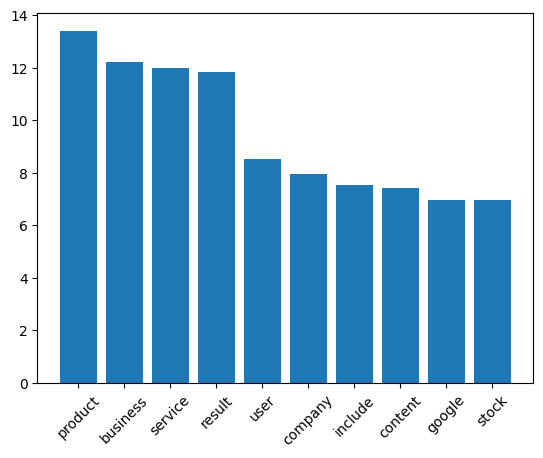

In [ ]:
tf_idf(google_2017_process, 10)

In [ ]:
lda_content_2017 = [content.split() for content in google_2017_process]
model_2017 = train_lda_model(lda_content_2017,num_topics=10,passes=10)
model_2017.print_topics()

[(0,
  '0.020*"report" + 0.019*"form" + 0.019*"content" + 0.018*"website" + 0.017*"k" + 0.014*"annual" + 0.009*"inc" + 0.009*"registrant" + 0.009*"statement" + 0.008*"quality"'),
 (1,
  '0.019*"product" + 0.018*"item" + 0.015*"user" + 0.015*"advertiser" + 0.014*"service" + 0.013*"advertising" + 0.010*"business" + 0.010*"result" + 0.009*"google" + 0.009*"help"'),
 (2,
  '0.023*"company" + 0.022*"stock" + 0.017*"stockholder" + 0.015*"director" + 0.013*"business" + 0.011*"affect" + 0.009*"result" + 0.009*"price" + 0.009*"class" + 0.008*"capital"'),
 (3,
  '0.031*"result" + 0.018*"business" + 0.015*"service" + 0.014*"change" + 0.014*"law" + 0.013*"product" + 0.012*"claim" + 0.011*"tax" + 0.011*"subject" + 0.010*"property"'),
 (4,
  '0.016*"exchange" + 0.015*"foreign" + 0.013*"tax" + 0.012*"market" + 0.012*"file" + 0.011*"act" + 0.011*"risk" + 0.011*"rate" + 0.009*"sec" + 0.009*"registrant"'),
 (5,
  '0.027*"content" + 0.020*"alphabet" + 0.014*"inc" + 0.014*"company" + 0.014*"table" + 0.010

In [ ]:
topic_model_2017 = BERTopic()
topics, probs = topic_model_2017.fit_transform(google_2017_process)

In [ ]:
topic_model_2017.get_topic_info().iloc[:, [0,1, 3]]

,Topic,Count,Representation
0,-1,68,"[product, result, business, service, operation..."
1,0,62,"[stock, class, item, stockholder, director, sh..."
2,1,47,"[advertising, revenue, advertiser, ad, device,..."
3,2,29,"[employee, service, product, business, personn..."
4,3,29,"[law, regulation, regulatory, business, court,..."
5,4,27,"[intellectual, property, claim, patent, right,..."
6,5,23,"[tax, rate, foreign, act, exchange, income, re..."
7,6,19,"[google, like, people, platform, help, digital..."
8,7,16,"[user, service, product, concern, security, ac..."
9,8,12,"[acquisition, strategic, transaction, benefit,..."


In [ ]:
topic_model_2017.visualize_barchart()

Top2Vec

In [ ]:
!pip install top2vec

In [ ]:
from top2vec import Top2Vec

In [ ]:
model_2023 = Top2Vec(google_content_process)
model_2017 = Top2Vec(google_2017_process)

2024-12-12 20:06:19,751 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2024-12-12 20:06:19,920 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
INFO:top2vec:Downloading all-MiniLM-L6-v2 model
2024-12-12 20:06:20,706 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-12-12 20:06:41,240 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-12-12 20:06:44,327 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-12-12 20:06:44,356 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2024-12-12 20:06:44,377 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2024-12-12 20:06:44,482 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
INFO:top2vec:Downloading all-MiniLM-L6

In [ ]:
topic_sizes, topic_nums = model_2023.get_topic_sizes()
topic_nums

array([0, 1, 2, 3])

In [ ]:
topic_words, word_scores, topic_nums = model_2023.get_topics()

In [ ]:
for words, socre, num in zip(topic_words, word_scores, topic_nums):
  print(num)
  print(f"Words: {words}")

0
Words: ['service' 'business' 'technology' 'product' 'ai' 'company' 'google'
 'financial' 'content' 'stock' 'continue' 'result' 'security' 'change'
 'risk' 'new' 'harm' 'law' 'user' 'include' 'condition' 'datum']
1
Words: ['law' 'business' 'technology' 'risk' 'financial' 'security' 'company'
 'product' 'service' 'harm' 'condition' 'stock' 'ai' 'result' 'content'
 'google' 'change' 'continue' 'include' 'new' 'datum' 'user']
2
Words: ['stock' 'financial' 'company' 'business' 'condition' 'law' 'security'
 'content' 'risk' 'include' 'continue' 'technology' 'product' 'service'
 'google' 'result' 'ai' 'change' 'datum' 'new' 'user' 'harm']
3
Words: ['security' 'risk' 'technology' 'service' 'datum' 'law' 'company'
 'business' 'product' 'ai' 'harm' 'financial' 'content' 'condition'
 'result' 'change' 'google' 'continue' 'user' 'new' 'stock' 'include']


In [ ]:
documents, document_scores, document_ids = model_2023.search_documents_by_topic(topic_num=0, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 64, Score: 0.7914350032806396
-----------
announce business deliver good product service experience s use rs advertiser partner customer developer believe approach ai bold responsible mean develop ai way maximize positive benefit
-----------

Document: 94, Score: 0.7646445631980896
-----------
decade product like performance max product studio use power ai help advertiser find untapped incremental conversion opportunity google service generate revenue primarily deliver performance brand advertising appear google search
-----------

Document: 169, Score: 0.7548748254776001
-----------
need product service expand investment ai entire company include generative ai continue integrate ai capability product service ai technology service highly competitive rapidly evolve require
-----------

Document: 93, Score: 0.7428027391433716
-----------
grow business wide range product device format aim ensure positive user experience serve right ad right time build deep partnership brand agen

In [ ]:
topic_sizes, topic_nums = model_2017.get_topic_sizes()
print(topic_nums)

topic_words, word_scores, topic_nums = model_2017.get_topics()

for words, socre, num in zip(topic_words, word_scores, topic_nums):
  print(num)
  print(f"Words: {words}")

[0 1]
0
Words: ['business' 'revenue' 'company' 'product' 'service' 'stock' 'google'
 'content' 'result' 'include' 'user']
1
Words: ['stock' 'company' 'business' 'revenue' 'content' 'include' 'service'
 'product' 'result' 'google' 'user']


2018

In [ ]:
google_2018 = page_extract("google-2018.pdf",chunk_size=300)
google_2018_process = pre_process(google_2018)

lda_content_2018 = [content.split() for content in google_2018_process]
model_2018 = train_lda_model(lda_content_2018,num_topics=10,passes=10)
model_2018.print_topics()

[(0,
  '0.014*"continue" + 0.013*"supply" + 0.012*"result" + 0.011*"term" + 0.011*"affect" + 0.011*"operating" + 0.011*"product" + 0.009*"future" + 0.008*"invest" + 0.008*"expectation"'),
 (1,
  '0.022*"business" + 0.020*"product" + 0.017*"service" + 0.015*"property" + 0.014*"technology" + 0.014*"law" + 0.012*"user" + 0.012*"revenue" + 0.011*"company" + 0.010*"new"'),
 (2,
  '0.023*"result" + 0.017*"law" + 0.016*"datum" + 0.012*"certain" + 0.009*"privacy" + 0.009*"regulation" + 0.009*"subject" + 0.008*"access" + 0.008*"security" + 0.007*"google"'),
 (3,
  '0.017*"business" + 0.016*"service" + 0.015*"product" + 0.013*"affect" + 0.012*"result" + 0.010*"include" + 0.010*"google" + 0.009*"margin" + 0.009*"alphabet" + 0.009*"access"'),
 (4,
  '0.025*"item" + 0.015*"statement" + 0.015*"business" + 0.012*"alphabet" + 0.012*"registrant" + 0.011*"company" + 0.011*"inc" + 0.011*"act" + 0.011*"result" + 0.010*"report"'),
 (5,
  '0.026*"product" + 0.022*"service" + 0.015*"advertising" + 0.013*"bus

In [ ]:
topic_model_2018 = BERTopic()
topics, probs = topic_model_2018.fit_transform(google_2018_process)

topic_model_2018.get_topic_info().iloc[:, [0,1, 3]]

,Topic,Count,Representation
0,-1,58,"[result, product, service, content, web, certa..."
1,0,125,"[google, advertising, revenue, product, busine..."
2,1,67,"[law, claim, business, intellectual, property,..."
3,2,59,"[stock, class, item, stockholder, share, direc..."
4,3,21,"[service, system, user, information, product, ..."
5,4,14,"[acquisition, strategic, transaction, risk, af..."


2019

In [ ]:
google_2019 = page_extract("google-2019.pdf",chunk_size=300)
google_2019_process = pre_process(google_2019)

lda_content_2019 = [content.split() for content in google_2019_process]
model_2019 = train_lda_model(lda_content_2019,num_topics=10,passes=10)
model_2019.print_topics()

[(0,
  '0.020*"product" + 0.017*"service" + 0.016*"business" + 0.015*"result" + 0.014*"financial" + 0.014*"property" + 0.014*"google" + 0.012*"harm" + 0.011*"intellectual" + 0.010*"alphabet"'),
 (1,
  '0.014*"ad" + 0.010*"advertising" + 0.010*"content" + 0.008*"continue" + 0.007*"product" + 0.007*"reference" + 0.006*"help" + 0.006*"stockholder" + 0.006*"business" + 0.006*"google"'),
 (2,
  '0.026*"result" + 0.020*"service" + 0.016*"product" + 0.014*"business" + 0.014*"user" + 0.013*"new" + 0.012*"operating" + 0.012*"financial" + 0.011*"change" + 0.010*"law"'),
 (3,
  '0.020*"business" + 0.015*"company" + 0.011*"result" + 0.010*"service" + 0.009*"include" + 0.008*"content" + 0.008*"google" + 0.007*"act" + 0.007*"investment" + 0.007*"filer"'),
 (4,
  '0.015*"claim" + 0.015*"product" + 0.014*"include" + 0.013*"service" + 0.012*"statement" + 0.012*"result" + 0.012*"certain" + 0.010*"employee" + 0.010*"report" + 0.009*"business"'),
 (5,
  '0.016*"include" + 0.015*"platform" + 0.013*"web" + 

In [ ]:
topic_model_2019 = BERTopic()
topics, probs = topic_model_2019.fit_transform(google_2019_process)

topic_model_2019.get_topic_info().iloc[:, [0,1, 3]]

,Topic,Count,Representation
0,-1,5,"[web, content, spam, quality, detect, low, pre..."
1,0,278,"[product, service, business, result, user, goo..."
2,1,74,"[stock, class, item, stockholder, share, capit..."


2020

In [ ]:
google_2020 = page_extract("google-2020.pdf",chunk_size=300)
google_2020_process = pre_process(google_2020)

lda_content_2020 = [content.split() for content in google_2020_process]
model_2020 = train_lda_model(lda_content_2020,num_topics=10,passes=10)
model_2020.print_topics()

[(0,
  '0.024*"result" + 0.021*"financial" + 0.019*"business" + 0.018*"product" + 0.016*"service" + 0.015*"harm" + 0.014*"condition" + 0.012*"include" + 0.011*"operating" + 0.009*"google"'),
 (1,
  '0.031*"content" + 0.020*"service" + 0.016*"product" + 0.016*"law" + 0.014*"business" + 0.012*"alphabet" + 0.012*"regulation" + 0.011*"inc" + 0.010*"new" + 0.010*"table"'),
 (2,
  '0.024*"business" + 0.016*"report" + 0.014*"include" + 0.013*"statement" + 0.010*"impact" + 0.010*"annual" + 0.009*"result" + 0.009*"risk" + 0.008*"form" + 0.008*"growth"'),
 (3,
  '0.035*"google" + 0.013*"user" + 0.013*"search" + 0.011*"ad" + 0.010*"cloud" + 0.009*"service" + 0.008*"advertiser" + 0.008*"product" + 0.007*"build" + 0.007*"business"'),
 (4,
  '0.023*"service" + 0.022*"product" + 0.020*"technology" + 0.019*"business" + 0.017*"new" + 0.012*"change" + 0.012*"advertising" + 0.011*"result" + 0.010*"include" + 0.010*"revenue"'),
 (5,
  '0.020*"stock" + 0.014*"share" + 0.013*"class" + 0.012*"market" + 0.012

In [ ]:
topic_model_2020 = BERTopic()
topics, probs = topic_model_2020.fit_transform(google_2020_process)

topic_model_2020.get_topic_info().iloc[:, [0,1, 3]]

,Topic,Count,Representation
0,-1,154,"[result, business, service, revenue, product, ..."
1,0,71,"[stock, class, item, stockholder, share, capit..."
2,1,37,"[google, advertiser, ad, search, advertising, ..."
3,2,29,"[intellectual, property, claim, trademark, pat..."
4,3,26,"[acquisition, term, transaction, supply, finan..."
5,4,24,"[law, regulation, business, content, service, ..."
6,5,17,"[covid, pandemic, disaster, natural, include, ..."
7,6,15,"[datum, security, attack, user, system, vulner..."
8,7,14,"[product, service, new, technology, business, ..."
9,8,13,"[carbon, energy, sustainability, climate, goog..."


In [ ]:
google_2020_process

['united states securities exchange commission washington dc form k mark annual report pursuant t o section d security exchange act fiscal year end',
 'december transition report pursuant t o section d security exchange act transition period commission file number alphabet inc exact registrant specify charter',
 'delaware state jurisdiction incorporation organization irs employer identification amphitheatre parkway mountain v iew address principal executive office include zip code',
 'registrant telephone number include area code security register pursuant section b act title class trading symbol exchange register class common stock par value googl nasdaq stock market llc nasdaq global select market class c',
 'capital stock par value goog nasdaq stock market llc nasdaq global select market security register pursuant section g act title class indicate check mark registrant know seasoned issuer',
 'define rule security act yes indicate check mark registrant require file report pursuant 

2021

In [ ]:
google_2021 = page_extract("google-2021.pdf",chunk_size=300)
google_2021_process = pre_process(google_2021)

lda_content_2021 = [content.split() for content in google_2021_process]
model_2021 = train_lda_model(lda_content_2021,num_topics=10,passes=10)
model_2021.print_topics()

[(0,
  '0.015*"result" + 0.010*"future" + 0.010*"system" + 0.009*"user" + 0.008*"disaster" + 0.008*"pandemic" + 0.008*"service" + 0.008*"company" + 0.008*"natural" + 0.007*"google"'),
 (1,
  '0.027*"business" + 0.016*"item" + 0.016*"service" + 0.013*"result" + 0.013*"financial" + 0.013*"include" + 0.011*"provider" + 0.011*"google" + 0.010*"harm" + 0.010*"cloud"'),
 (2,
  '0.017*"service" + 0.016*"revenue" + 0.014*"product" + 0.012*"increase" + 0.011*"business" + 0.010*"advertising" + 0.009*"harm" + 0.008*"financial" + 0.008*"include" + 0.008*"rate"'),
 (3,
  '0.039*"stock" + 0.032*"class" + 0.026*"report" + 0.017*"share" + 0.016*"stockholder" + 0.015*"registrant" + 0.014*"c" + 0.014*"form" + 0.014*"k" + 0.013*"annual"'),
 (4,
  '0.024*"law" + 0.023*"business" + 0.018*"result" + 0.018*"regulation" + 0.017*"change" + 0.017*"service" + 0.016*"product" + 0.013*"affect" + 0.012*"new" + 0.012*"subject"'),
 (5,
  '0.022*"google" + 0.015*"product" + 0.013*"include" + 0.012*"datum" + 0.012*"pri

In [ ]:
topic_model_2021 = BERTopic()
topics, probs = topic_model_2021.fit_transform(google_2021_process)

topic_model_2021.get_topic_info().iloc[:, [0,1, 3]]

,Topic,Count,Representation
0,-1,159,"[business, result, service, product, financial..."
1,0,47,"[google, cloud, service, product, generate, ad..."
2,1,32,"[sustainability, carbon, employee, report, key..."
3,2,30,"[stock, class, stockholder, share, director, c..."
4,3,30,"[intellectual, property, claim, trademark, pat..."
5,4,24,"[datum, system, security, attack, vulnerabilit..."
6,5,20,"[tax, rate, foreign, international, exchange, ..."
7,6,18,"[revenue, rate, growth, expectation, margin, f..."
8,7,18,"[regulation, law, new, compliance, subject, re..."
9,8,17,"[report, form, investor, website, reference, i..."


2022

In [ ]:
google_2022 = page_extract("google-2022.pdf",chunk_size=300)
google_2022_process = pre_process(google_2022)

lda_content_2022 = [content.split() for content in google_2022_process]
model_2022 = train_lda_model(lda_content_2022,num_topics=10,passes=10)
model_2022.print_topics()

[(0,
  '0.022*"result" + 0.019*"harm" + 0.019*"product" + 0.017*"business" + 0.012*"claim" + 0.012*"financial" + 0.011*"service" + 0.011*"intellectual" + 0.011*"legal" + 0.010*"property"'),
 (1,
  '0.019*"law" + 0.015*"business" + 0.015*"regulation" + 0.014*"datum" + 0.012*"user" + 0.011*"product" + 0.011*"change" + 0.011*"harm" + 0.010*"practice" + 0.010*"result"'),
 (2,
  '0.028*"product" + 0.024*"service" + 0.016*"business" + 0.014*"company" + 0.010*"continue" + 0.009*"significant" + 0.008*"result" + 0.008*"certain" + 0.008*"affect" + 0.007*"harm"'),
 (3,
  '0.018*"business" + 0.015*"google" + 0.013*"service" + 0.013*"product" + 0.010*"technology" + 0.008*"law" + 0.008*"alphabet" + 0.008*"regulation" + 0.006*"include" + 0.006*"collection"'),
 (4,
  '0.017*"user" + 0.017*"advertising" + 0.016*"service" + 0.016*"advertiser" + 0.015*"product" + 0.012*"privacy" + 0.011*"google" + 0.010*"include" + 0.010*"provider" + 0.008*"content"'),
 (5,
  '0.034*"stock" + 0.024*"class" + 0.012*"regis

In [ ]:
topic_model_2022 = BERTopic()
topics, probs = topic_model_2022.fit_transform(google_2022_process)

topic_model_2022.get_topic_info().iloc[:, [0,1, 3]]

,Topic,Count,Representation
0,-1,50,"[content, quality, service, user, access, incl..."
1,0,136,"[stock, result, financial, class, item, busine..."
2,1,103,"[product, service, google, business, advertisi..."
3,2,44,"[datum, privacy, security, law, system, user, ..."
4,3,27,"[property, intellectual, claim, trademark, pat..."
5,4,16,"[regulation, law, subject, business, new, gove..."
6,5,15,"[sustainability, carbon, report, water, energy..."


Getting topic trend over time:

In [ ]:
import pandas as pd

data = {2017: google_2017_process,2018:google_2018_process, 2019: google_2019_process, 2020: google_2020_process, 2021: google_2021_process, 2022: google_2022_process, 2023: google_content_process}

def create_yearly_documents(data):
    documents = []

    for year, doc_list in data.items():
        for doc in doc_list:
            documents.append((doc, year))

    return documents

documents = create_yearly_documents(data)

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(documents, columns=['text', 'year'])

print(df)

                                                   text  year
0     united st ates securities exchange commission ...  2017
1     december transition report pursuant t o sectio...  2017
2     delaware state jurisdiction incorporation orga...  2017
3     telephone number include area code security re...  2017
4     class c capital stock par value nasdaq stock m...  2017
...                                                 ...   ...
2673  content alphabet inc issuer purchase equity se...  2023
2674  class c share purchase thousandsaverage price ...  2023
2675  million october november december total r epur...  2023
2676  business market condition investment opportuni...  2023
2677  note consolidate financial statement include i...  2023

[2678 rows x 2 columns]


In [ ]:
topic_model = BERTopic()

text = df['text'].tolist()

topics, probs = topic_model.fit_transform(text)

timestamps = df["year"].to_list()

topics_over_time = topic_model.topics_over_time(text, timestamps)

# Visualize topics over time
topic_model.visualize_topics_over_time(topics_over_time)

In [ ]:
# Visualize topics over time
topics_of_interest = [0, 7, 17, 75]

# Visualize the selected topics over time
topic_model.visualize_topics_over_time(topics_over_time, topics = topics_of_interest)

The evolution of topics in Google’s 10-K forms from 2017 to 2023 reveals intriguing patterns, particularly when segmented into pre-pandemic, pandemic, and post-pandemic phases. Before COVID-19, the focus centered heavily on traditional business operations, including advertising, intellectual property, stockholder matters, and regulatory concerns. During the pandemic in 2020, discussions shifted to include the impacts of COVID-19, such as disruptions in operations and risk factors. Topics like cybersecurity, privacy, and sustainability began to gain prominence during this period, reflecting broader industry and societal concerns. By 2023, the emergence of AI as a key topic alongside increasing discussions about cybersecurity and sustainability underscored a strategic pivot toward cutting-edge technology and corporate responsibility.

The discussion of Artificial Intelligence (AI) experienced a notable rise between 2017 and 2023. Early mentions of AI were scattered, focusing on specific use cases like Google Cloud and advertising technology. By 2023, AI became a central theme, with terms like "platform," "device," and "user" being closely associated with AI discussions. This change mirrors Google’s broader market positioning as a leader in AI innovation, as evidenced by its growing investments in AI-powered search and devices. The prominence of AI in 2023 suggests a deliberate strategy to highlight its leadership in this area to stakeholders.

When examining the similarities and differences in topics across the 2017–2023 period, certain themes like intellectual property, stockholder matters, and regulatory compliance remained consistent. However, there was a dynamic shift in emphasis on sustainability, cybersecurity, and AI in later years. Sustainability topics, including carbon reduction and diversity, were almost absent in earlier years but gained traction in 2021 and beyond. Similarly, cybersecurity risks became more explicit in 2020, reflecting the increasing importance of protecting user data amid growing system vulnerabilities. Meanwhile, traditional topics like intellectual property and regulatory compliance persisted, underscoring their long-term relevance to Google's business model.

These findings affirm the hypotheses to varying degrees. The COVID-19 pandemic significantly reshaped the thematic focus, introducing new risks and priorities that persisted even after the crisis abated. The rapid increase in AI mentions validates the hypothesis that AI gained prominence, particularly as Google aligned its corporate narrative with technological innovation. Lastly, while certain foundational topics have remained stable over time, the shifting emphasis on emerging issues like sustainability and cybersecurity illustrates how Google's priorities have evolved to address changing market and societal demands.

For chunking, tried 1000 and 800 but for those the Bertopic visualization didnt work.

For 500, it didnt give a lot more topics compared to 300 which gave more and intersting topics too.